# Случайный лес

В этом практическом задании вы решите задачу регрессии на реальных данных при помощи линейной модели и случайного леса. 

## Цели практической работы

* Научиться применять случайный лес в задаче регрессии.
* Научиться сравнивать качество случайного леса с качеством линейной модели.
* Научиться настраивать гиперпараметры леса.

## Что входит в работу

* Выполнить предобработку данных.
* Обучить линейную регрессию на данных задачи.
* Обучить случайный лес на данных задачи.
* Подобрать гиперпараметры для леса.
* Визуализировать важность признаков у леса.

## Что оценивается

*  Все ячейки заполнены; при запуске ячеек  Python не выдаёт информацию об ошибках.
*  Качество итоговой модели $R^2$ превышает 0,95.


## Что нужно сделать

Постройте модели, предсказывающие стоимость автомобилей по характеристикам.

Признаков у машин много, но в этой работе обойдёмся только числовыми признаками:
*  year — год производства автомобиля;
*  km_driven — пробег;
*  seats — количество посадочных мест;
*  mileage — другая характеристика пробега;
*  engine — мощность двигателя;
*  max_power — мощность автомобиля.

Целевая переменная — selling_price.

# 0. Data loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import pandas as pd
import numpy as np

import eda_functions
import modeling_functions
import feat_eng_functions

from xgboost import XGBRegressor   
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from ydata_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor,
    VotingRegressor,
    ExtraTreesRegressor,
    BaggingRegressor,
    StackingRegressor,
)

warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv("data/cars_train.csv").rename(columns={"selling_price": "target"})
test_df = pd.read_csv("data/cars_test.csv").rename(columns={"selling_price": "target"})

In [4]:
train_df.head()

,name,year,target,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014.0,450000.0,145500.0,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014.0,370000.0,120000.0,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010.0,225000.0,127000.0,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,"Maruti Swift VXI BSIII,2007,130000,120000,Petr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hyundai Xcent 1.2 VTVT E Plus,2017.0,440000.0,45000.0,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0


# I. ОТКАТАЕМ ОБЯЗАТЕЛЬНУЮ ПРОГРАММУ

<img src="data/понеслась.gif" alt="GIF" style="width:500px; height:auto;">

In [5]:
print(f"{train_df.shape}\n\n{test_df.shape}")

(6998, 13)

(1000, 13)


In [6]:
train_df = train_df[train_df["target"].notna()]
train_df.shape

(6699, 13)

Создайте объекты Xtrain, ytrain, Xtest, ytest. Запишите в них матрицы «объект — признак» и векторы целевой переменной для тренировочного и тестового датасетов.

In [7]:
X_train = train_df.drop(columns=["target"])
y_train = train_df["target"]
X_test = test_df.drop(columns=["target"])
y_test = test_df["target"]

### Тому, кто подставил здесь код с train_test_split надо перегрызть сухожилия ног. Сделал работу, а потом только допёр, что надо было делить без него.

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(
#     working_df.drop(columns=["target"]), working_df["target"], test_size=0.3
# )

В тренировочных данных есть автомобили, для которых неизвестна стоимость. Удалите эти автомобили из трейна.

#### Может, имело смысл сделать это до разделения на рабочий датасет и вектор целевой переменной?

In [9]:
# Перед обучением моделей обработайте данные.

text = """Обратите внимание, что столбцы mileage, engine и max_power 
по смыслу числовые. Чтобы превратить их в числовые столбцы, отбросьте 
единицы измерения и оставьте только числа. В столбцах есть пропущенные 
значения, их при обработке трогать не нужно."""

In [10]:
X_train = eda_functions.str_to_float(X_train, text)
X_test = eda_functions.str_to_float(X_test, text)
X_train.head(2)

,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014.0,145500.0,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014.0,120000.0,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0


In [11]:
# Оставьте в данных только шесть числовых столбцов:

upper_str = "year, km_driven, seats, engine, mileage, max_power"

In [12]:
working_cols = [x for x in upper_str.split(", ") if x in X_train.columns]
X_train = X_train[working_cols]
X_test = X_test[working_cols]
X_train.head()

,year,km_driven,seats,engine,mileage,max_power
0,2014.0,145500.0,5.0,1248.0,23.40,74.00
1,2014.0,120000.0,5.0,1498.0,21.14,103.52
2,2010.0,127000.0,5.0,1396.0,23.00,90.00
4,2017.0,45000.0,5.0,1197.0,20.14,81.86
6,2001.0,5000.0,4.0,796.0,16.10,37.00


Теперь заполните пропуски следующим образом:

*    вычислите средние значения по столбцам тренировочной выборки;

*    добавьте в пропуски в тренировочных и тестовых данных вычисленные средние.

In [13]:
X_train = eda_functions.fill_with_mode(X_train)
X_test = eda_functions.fill_with_mode(X_test)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6699 entries, 0 to 6997
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   year       6699 non-null   float64
 1   km_driven  6699 non-null   float64
 2   seats      6699 non-null   float64
 3   engine     6699 non-null   float64
 4   mileage    6699 non-null   float64
 5   max_power  6699 non-null   float64
dtypes: float64(6)
memory usage: 366.4 KB


Теперь на обработанных тренировочных данных обучите:

*  линейную регрессию,
*  случайный лес с параметрами по умолчанию.

На обработанных тестовых данных сделайте предсказание и вычислите метрику $R^2$. 

In [14]:
splits = [X_train, y_train, X_test, y_test]
models = (
    LinearRegression(),
    RandomForestRegressor(),
    ExtraTreesRegressor(),
    BaggingRegressor(), # bagging
    BaggingRegressor(bootstrap=False), # pasting
    SVR(), # он тут явно лишний, но всё же пусть заимеет свой голос
    
)

modeling_functions.get_r2_score(models, splits)

R2 score for LinearRegression: 64.91%
R2 score for RandomForestRegressor: 96.53%
R2 score for ExtraTreesRegressor: 97.50%
R2 score for BaggingRegressor: 95.74%
R2 score for BaggingRegressor: 96.12%
R2 score for SVR: -4.31%


In [15]:
# Позволю себе немного вольностей:

lr, rf, extra_rf, bag, pasting, svr = models

estimators = [
    ("lr", lr),
    ("rf", rf),
    ("extra_rf", extra_rf),
    ("bag", bag),
    ("pasting", pasting),
    ("svr", svr),
]

vot = VotingRegressor(estimators=estimators, n_jobs=-1)
stack = StackingRegressor(
    estimators=estimators, final_estimator=ExtraTreesRegressor(), n_jobs=-1
)

modeling_functions.get_r2_score([vot, stack], splits)

R2 score for VotingRegressor: 91.49%
R2 score for StackingRegressor: 97.26%


Учитывая, что lr и svr портят нам тут всю картину, попробуем от них избавиться:

In [16]:
rf, extra_rf, bag, pasting = models[1:-1]

estimators = [
    ("rf", rf),
    ("extra_rf", extra_rf),
    ("bag", bag),
    ("pasting", pasting),
]

vot = VotingRegressor(estimators=estimators, n_jobs=-1)
stack = StackingRegressor(
    estimators=estimators, final_estimator=ExtraTreesRegressor(), n_jobs=-1
)

modeling_functions.get_r2_score([vot, stack], splits)

R2 score for VotingRegressor: 97.03%
R2 score for StackingRegressor: 96.46%


##### Мда, чуда не произошло. Экстремальный лес побить не удалось, но всё равно хорошо.

Ещё немного магических заклинаний

In [17]:
estimators = [
    ("rf", rf),
    ("extra_rf", extra_rf),
    ("bag", bag),
    ("pasting", pasting),
    ("xgb", XGBRegressor()),
    ("cbr", CatBoostRegressor(logging_level="Silent")),
    ("lgbm", LGBMRegressor(verbose=-1)),
]

vot = VotingRegressor(estimators=estimators, n_jobs=-1)
stack = StackingRegressor(
    estimators=estimators, final_estimator=ExtraTreesRegressor(), n_jobs=-1
)


modeling_functions.get_r2_score([vot, stack], splits)

R2 score for VotingRegressor: 97.36%
R2 score for StackingRegressor: 97.71%


Попробуем улучшить результаты

### ФигА!!! Уот это результат!!! 

Ну и напоследок... 

In [18]:
# XGBoostRegressor
xgb_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 1
}

# LightGBMRegressor
lgbm_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': -1,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'verbose': -1
}

# CatBoostRegressor
catboost_params = {
    'iterations': 500,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'bagging_temperature': 1,
    'random_strength': 1,
    'logging_level': "Silent"
}

# LinearRegressor
linear_params = {
    'fit_intercept': True,
    'n_jobs': -1
}


# RandomForestRegressor
random_forest_params = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'n_jobs': -1
}

# ExtraTreesRegressor
extra_trees_params = {
    'n_estimators': 500,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'n_jobs': -1
}

# BaggingRegressor
bagging_params = {
    'n_estimators': 100,
    'max_samples': 0.8,
    'max_features': 0.8,
    'bootstrap': True,
    'bootstrap_features': False,
    'n_jobs': -1
}

estimators = [
    ("xgb", XGBRegressor(**xgb_params)),
    ("lgbm", LGBMRegressor(**lgbm_params)),
    ("catboost", CatBoostRegressor(**catboost_params)),
    # ("lr", LinearRegression(**linear_params)),
    # ("rf", RandomForestRegressor(**random_forest_params)),
    # ("extra_rf", ExtraTreesRegressor(**extra_trees_params)),
    # ("bag", BaggingRegressor(**bagging_params)),
]

vot = VotingRegressor(estimators=estimators, n_jobs=-1)
stack = StackingRegressor(
    estimators=estimators, final_estimator=ExtraTreesRegressor(), n_jobs=-1
)


modeling_functions.get_r2_score([vot, stack], splits)

R2 score for VotingRegressor: 97.43%
R2 score for StackingRegressor: 96.91%


Какая модель получилась лучше?

#### Стэкинг из бустеров. 

Улучшите качество предсказания случайного леса путём подбора гиперпараметров:

*   n_estimators,
*   max_depth,
*   max_features,
*   min_samples_leaf,
*   min_samples_split.

Для подбора гиперпараметров используйте GridSearchCV. Обучайте GridSearchCV по тренировочным данным с разбивкой на три фолда и метрикой $R^2$.

In [19]:
rf = RandomForestRegressor()

# Я тут всякого перебровал, но улучшить ничего особо не получилось 
# ни при каких параметрах
param_grid = {
    "n_estimators": [100],
    "max_depth": np.arange(1, 10, 1),
    "max_features": ["log2"],
    "min_samples_leaf": [1],
    "min_samples_split": [2],
    "ccp_alpha": [0.01],
}

best_rf = modeling_functions.tune_model(rf, param_grid, X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
The best parameters for RandomForestRegressor:
{'ccp_alpha': 0.01, 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}



Теперь обучите на тренировочных данных случайный лес с найденными гиперпараметрами. Сделайте предсказание на тестовых данных и оцените его качество ($R^2$).

In [20]:
modeling_functions.get_r2_score([best_rf], splits)

R2 score for RandomForestRegressor: 95.65%


#### После подбора гиперпараметров показатель $R^2$ модели ухудшился.

Модель готова. Осталось её проинтерпретировать.

При помощи метода model.feature_importances_ визуализируйте гистограмму важности признаков у случайного леса с настроенными гиперпараметрами.

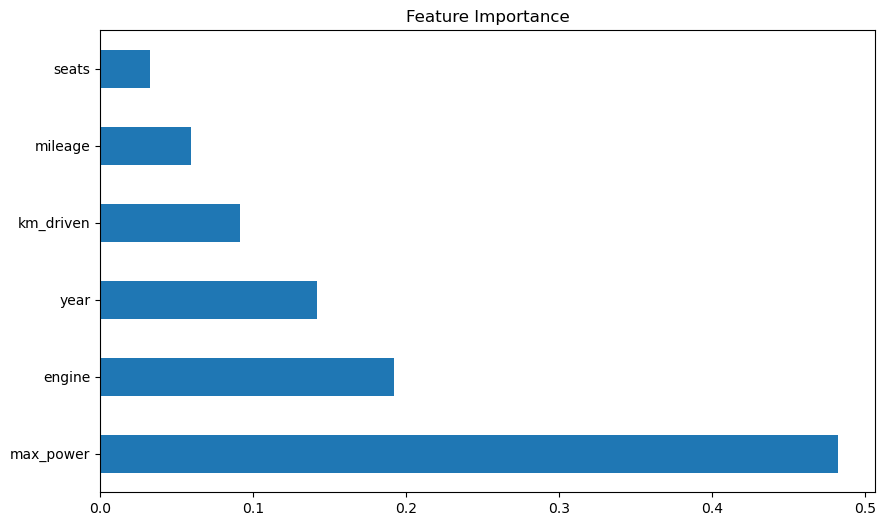

In [21]:
modeling_functions.plot_feature_importances(best_rf, X_train)

(6699, 6)


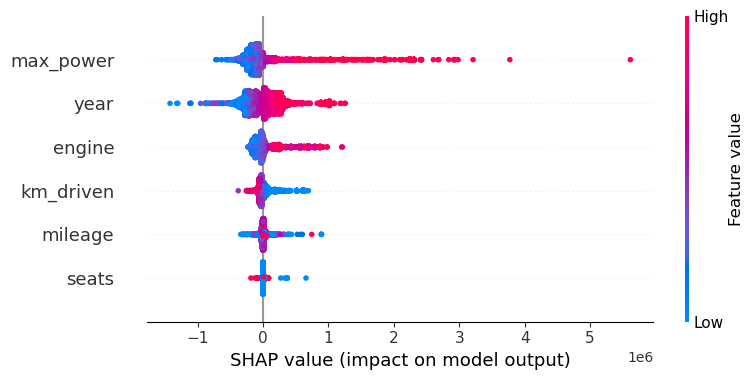

In [22]:
import shap
from catboost import Pool

pool = Pool(data=X_train, label=y_train)
cb = CatBoostRegressor(logging_level="Silent")
cb.fit(X_train, y_train)
shap_values = cb.get_feature_importance(pool, type="ShapValues")

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

print(shap_values.shape)
shap.summary_plot(shap_values, X_train)

Shap-values для конкретного объекта.

In [23]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3, :], X_train.iloc[3, :])

# ВЫВОДЫ.

#### Вывод №1.
Изучив все материалы по теме, которые были у меня в наличии (а это: Соколов, семинары, Жерон и наш курс (как-то скудненько она в этот раз)), я располагаю следующими подходами:
- bagging & pasting;
- voting;
- random & extreme forests;
- AdaBoost;
- GradientBoost & XGBoost;
- LightGBM & CatBoost;
- Stacking;
- Blending.

Здесь отработал авоськование и размазывание (bagging & pasting), голосование обычное и стековое, случайные и экстремальные леса, бустинги (за исключением Ады и Градиента, т.к. они лежат в основе трёх использованных мною).

Это было круто, чё. Блендинг мне уже было лень, да и говорят, что он не сильно отличается от стэкинга — мол, только пошустрее будет.

#### Вывод №2.
Абсолютно все модели, как бы я ни колдовал (в т.ч. см. раздел для взрослых ниже), при подборе параметров показывали результат хуже бейзлайна.

#### Вывод №3.
Экстремальные леса рулят!!! Их смогли одолеть лишь бустинги и то, накинувшись шоблой.

#### Вывод №4.
Настороженно потыкал палкой в значения Шапли. Пока ничего толкового сказать не могу, но выглядит пёстренько (где-то насторожился РКН).

#### Вывод №4.
Я устал, я мухожук. Реально собирался полностью повторить семинары по бустингам из ВШЭ, но чую, что сил моих не хватит на всё. Кроме того, я собирался создать модель, чтобы она ещё более-менее точно предсказывала стоимость, но что-то пошло не так и все мои страдания оказались напрасны и были вынесены в соответствующий подраздел. Между прочим, CatBoost там выступил лучше всех по метрике МАЕ.

# XXX. ~~ПИЗДО~~СТРАДАНИЯ

## 1. EDA

Снова определим данные

In [24]:
df = pd.concat([train_df, test_df])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7699 entries, 0 to 999
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          7699 non-null   object 
 1   year          7699 non-null   float64
 2   target        7699 non-null   float64
 3   km_driven     7699 non-null   float64
 4   fuel          7699 non-null   object 
 5   seller_type   7699 non-null   object 
 6   transmission  7699 non-null   object 
 7   owner         7699 non-null   object 
 8   mileage       7478 non-null   object 
 9   engine        7478 non-null   object 
 10  max_power     7484 non-null   object 
 11  torque        7478 non-null   object 
 12  seats         7478 non-null   float64
dtypes: float64(4), object(9)
memory usage: 842.1+ KB


In [25]:
df = eda_functions.str_to_float(df, text)
df.head()

,name,year,target,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014.0,450000.0,145500.0,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014.0,370000.0,120000.0,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010.0,225000.0,127000.0,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017.0,440000.0,45000.0,Petrol,Individual,Manual,First Owner,20.14,1197.0,81.86,113.75nm@ 4000rpm,5.0
6,Maruti 800 DX BSII,2001.0,45000.0,5000.0,Petrol,Individual,Manual,Second Owner,16.10,796.0,37.00,59Nm@ 2500rpm,4.0


In [26]:
# profile = ProfileReport(df, title="Car Sales Data Report", explorative=True)
# profile.to_notebook_iframe()

Итак, в отчёте нашлись дубликаты. Удалим их.

In [27]:
df = df.drop_duplicates()


Удалим выбросы

In [28]:
df = df[~(
    (df.target > 5000000) | (df.target < 10000) &
    (df.year < 2000) &
    (df.km_driven > 200000) | (df.km_driven < 1000) &
    (df.mileage < 10) | (df.mileage > 30) &
    (df.max_power < 30) | (df.max_power > 500) &
    (df.seats < 4) | (df.seats > 9)
)]

Кроме того, мы видим, что некоторые признаки являются категориальными с небольшим количеством категорий.

In [29]:
df.name = df.name.apply(lambda x: x.split()[0])

In [30]:
cols_to_cat = ["fuel", "seller_type", "transmission", "owner", "name"]
for col in cols_to_cat:
    df[col] = df[col].astype("category").cat.codes

df.head()

,name,year,target,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,19,2014.0,450000.0,145500.0,1,1,1,0,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,26,2014.0,370000.0,120000.0,1,1,1,2,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,11,2010.0,225000.0,127000.0,1,1,1,0,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
4,11,2017.0,440000.0,45000.0,3,1,1,0,20.14,1197.0,81.86,113.75nm@ 4000rpm,5.0
6,19,2001.0,45000.0,5000.0,3,1,1,2,16.10,796.0,37.00,59Nm@ 2500rpm,4.0


Заполним пропуски модой.

In [31]:
df = eda_functions.fill_with_mode(df)

## 2. Feature engineering

In [32]:
df = feat_eng_functions.engineer_features(df)

['car_age', 'km_per_year', 'owner_age_ratio', 'torque', 'power_to_engine_ratio', 'mileage_per_power', 'performance_score', 'power_per_seat']


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6513 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   6513 non-null   int8   
 1   year                   6513 non-null   float64
 2   target                 6513 non-null   float64
 3   km_driven              6513 non-null   float64
 4   fuel                   6513 non-null   int8   
 5   seller_type            6513 non-null   int8   
 6   transmission           6513 non-null   int8   
 7   owner                  6513 non-null   int8   
 8   mileage                6513 non-null   float64
 9   engine                 6513 non-null   float64
 10  max_power              6513 non-null   float64
 11  torque                 6513 non-null   float64
 12  seats                  6513 non-null   float64
 13  car_age                6513 non-null   float64
 14  km_per_year            6513 non-null   float64
 15  owner_age_

## 3. Modeling

In [34]:
X = df.drop(columns=["target", "name"])
y = df["target"]    

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=137
)

splits = [X_train, y_train, X_test, y_test]

Именно из-за него я страдал, т.к. LGBM & CatBoost не требуют выплясывания с категориями.

In [36]:
models = XGBRegressor(), CatBoostRegressor(logging_level='Silent'), LGBMRegressor(verbose=-1)

modeling_functions.get_mae_score(models, splits)

MAE score for XGBRegressor: 79331.00
MAE score for CatBoostRegressor: 72994.46
MAE score for LGBMRegressor: 76059.51


Чисто ради интереса:

In [37]:
splits = [X_train, y_train, X_test, y_test]
models = (
    LinearRegression(),
    RandomForestRegressor(),
    ExtraTreesRegressor(),
    BaggingRegressor(), # bagging
    BaggingRegressor(bootstrap=False), # pasting
    SVR(), # он тут явно лишний, но всё же пусть заимеет свой голос
)

modeling_functions.get_r2_score(models, splits)

R2 score for LinearRegression: 71.69%
R2 score for RandomForestRegressor: 88.94%
R2 score for ExtraTreesRegressor: 89.73%
R2 score for BaggingRegressor: 88.31%
R2 score for BaggingRegressor: 84.09%
R2 score for SVR: -3.63%
